In [24]:
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import const
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import re

In [25]:
### Fonction permettant l'extraction des couleurs principales d'une image

# Fonctions annexes
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def iqr(x):
    return q3(x) - q1(x) 

# Fonctions extraction
def extract_colors_img(file_path, nb_colors, without_bkg):
    """ Prend en argument :
            - le chemin de l'image
            - le nombre de couleurs à extraire
            - si l'image est détourée (True) ou non (False) 
            
        Retourne une liste contenant les indicateurs de position (moyenne, médiane, Q1, Q3) 
        et de dispersion (écart type et écart interquartile ) par couleur"""

    img = cv2.imread(file_path)

    # Largeur et hauteur de l'image pour traitements
    img_width = 120
    img_height = 120

    # seuil érosion
    seuil_ero = 2

    # Redimensionnement de l'image
    img_color = cv2.resize(img, dsize = (img_width,img_height)) 

    # Passage en noir et blanc pour stats et érosion si image détourée (without_bkg = True)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    if without_bkg == True:

        # Érosion
        kernel = np.ones((4,4),np.uint8)
        erosion = cv2.erode(img_gray, kernel)

        erosion = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
        erosion = erosion.reshape(img_width*img_height, 3)

        # Application érosion à l'image en noir et blanc
        img_sort_gray = img_gray.reshape(img_width*img_height, 1)
        img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) | (erosion[:,1] > seuil_ero) | 
                                      (erosion[:,2] > seuil_ero)]

        # Test découpage couleur (de la + foncée à la + claire) et ajustement seuil si besoin
        decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors), axis=0))

        # Ajustement seuil érosion (5 maximum)
        while len(np.unique(decoup)) <= nb_colors and seuil_ero < 5:
            seuil_ero += 1
            img_sort_gray = img_gray.reshape(img_width*img_height, 1)
            img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                    (erosion[:,1] > seuil_ero) | 
                                    (erosion[:,2] > seuil_ero)]
            decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors), axis=0))

        # Exlusion des pixels totalement blancs (problème image)
        erosion[(erosion[:,0] > (255 - seuil_ero)) & 
                (erosion[:,1] > (255 - seuil_ero)) & 
                (erosion[:,2] > (255 - seuil_ero))] = 0

        # Application érosion sur image couleur
        img_sort_color = img_color.reshape(img_width*img_height, 3).copy()

        img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                        (erosion[:,1] > seuil_ero) |
                                        (erosion[:,2] > seuil_ero)]

        # Application érosion sur image noir et blanc
        img_sort_gray = img_gray.reshape(img_width*img_height, 1).copy()
        img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                      (erosion[:,1] > seuil_ero) | 
                                      (erosion[:,2] > seuil_ero)]

    else:
        seuil_ero = 5

        # Exlusion des pixels totalement blancs (problème image)
        erosion = img_color.reshape(img_width*img_height, 3).copy()
        erosion[(erosion[:,0] > (255 - seuil_ero)) & 
                (erosion[:,1] > (255 - seuil_ero)) & 
                (erosion[:,2] > (255 - seuil_ero))] = 0

        # Application érosion sur image couleur
        img_sort_color = img_color.reshape(img_width*img_height, 3)

        img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                        (erosion[:,1] > seuil_ero) |
                                        (erosion[:,2] > seuil_ero)]

        # Application erosion à image en noir et blanc
        img_sort_gray = img_gray.reshape(img_width*img_height, 1)
        img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                                      (erosion[:,1] > seuil_ero) | 
                                      (erosion[:,2] > seuil_ero)]

    # Découpage sur R + G + B
    decoup_source = np.sum(img_sort_color, axis=1)
    decoup_source.shape = (len(decoup_source), 1)
    decoup_source = np.concatenate([img_sort_color, decoup_source], axis = 1)
    decoup = list(np.percentile(decoup_source[:, 3], np.arange(0, 101, 100/nb_colors), axis=0))

    # Modification découpage si nombre de valeurs distinctes toujours pas ok
    cpt = 0
    if len(np.unique(decoup)) <= nb_colors:
        decoup_temp = decoup.copy()
        decoup.clear()
        for val in decoup_temp:
            # print(decoup)
            while val <= (cpt + 1):
                val = val + 2
            # print('Ajout')
            cpt = val
            decoup.append(int(val))

    
    # Passage en DataFrame
    df_img_gray = pd.DataFrame(img_sort_gray, columns=['Gray'])
    df_img_color = pd.DataFrame(decoup_source, columns=['B','G','R','TOT'])

    df_img = pd.concat([df_img_gray, df_img_color], axis=1)

    # Découpage couleurs
    nom_inter = []
    for inter in range(1, nb_colors+1, 1):
        nom_inter.append(f'C{str(inter)}')

    df_img['decoup'] = pd.cut(x = df_img['TOT'], bins = decoup, labels = nom_inter, include_lowest = True)

    # Calcul des indicateurs
    calculs = {'R':['mean', 'std', 'median', q1, q3, iqr],
               'G':['mean', 'std', 'median', q1, q3, iqr],
               'B':['mean', 'std', 'median', q1, q3, iqr],
               'Gray':['mean', 'std', 'median', q1, q3, iqr]}

    df_img_sort = df_img.groupby('decoup', as_index=False).agg(calculs).round(1)
    
    # Renommage des colonnes
    df_img_sort = df_img_sort.set_axis(df_img_sort.columns.map('_'.join), axis=1)

    # Gestion des valeurs manquantes
    df_img_sort['Test_NaN'] = df_img_sort.isna().any(axis = 1)

    for i in range(0, nb_colors, 1):
        # print(f"test C{i+1}")
        if df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']['Test_NaN'].values == True:
            # Récupération données classe précédente
            df_img_sort.iloc[i,1:25] = df_img_sort.iloc[i-1, 1:25]

    df_img_sort = df_img_sort.drop('Test_NaN', axis=1)
    
    # Passage des informations en liste avec toutes les infos sur 1 ligne
    rep_color_img = []
    for i in range(0, df_img_sort.shape[0]):
        if i == 0:
            rep_color_img = list(df_img_sort.iloc[i,-24:])
        else:
            rep_color_img.extend(list(df_img_sort.iloc[i,-24:]))

    return rep_color_img


In [26]:
### Fonction pour création d'un dataframe contenant les différentes couleurs par image avec leurs
# métriques associées

def create_df_color(dirDsPath, nb_colors, without_bkg=False):
    """ Prend en argument :
            - le dossier d'images à traiter
            - le nombre de couleurs à extraire par image
            - si l'image est détourée (True) ou non (False)
        
        Teste si le fichier csv correspondant existe déjà :
            - si présent, le charge, sinon le crée

        Retourne un DataFrame contenant les indicateurs de position (moyenne, médiane, Q1, Q3) 
        et de dispersion (écart type et écart interquartile ) par couleur pour toutes les images du
        dossier """

    # Teste si le fichier texte correspondant existe déjà
    if without_bkg == False:
        filename = f'ML_maincolors{nb_colors}.csv'
    else:
        filename = f'ML_maincolors{nb_colors}_det.csv'
    
    ML_file_path = os.path.join(const.DATA_ML_PATH, filename)

    if not os.path.isfile(ML_file_path):
        print('Fichier non existant, création du fichier', '\n') 

        # Liste des échantillons à disposition
        ech = [setPath for setPath in os.listdir(dirDsPath)]

        # Initialisation
        l_img_coul = []

        for source in ech:
            #Chemin de l'échantillon
            path_ech = os.path.join(dirDsPath, source)

            # Parcourt les dossiers pour l'échantillon concerné (1 dossier = 1 classe)
            for folder in os.listdir(path_ech):
                # Chemin de la classe
                path_class = os.path.join(path_ech, folder)
                print(source, folder)
                
                # Parcourt les images à l'intérieur du dossier (classe)
                for items in os.listdir(path_class):
                    # Extraction informations couleurs de l'image
                    l_img_temp = extract_colors_img(os.path.join(path_class, items), 
                                                    nb_colors, 
                                                    without_bkg)
                    
                    # Ajout des informations echantillon / classe / image
                    l_img_temp.extend([source, folder, items])

                    # Insertion à liste finale
                    l_img_coul.append(l_img_temp)

        # Création d'une liste contenant les libellés de colonne pour DF
        nom_col_df = []
        for d in range(1, nb_colors+1):
            for c in ['R', 'G', 'B', 'Gray']:
                for m in ['mean', 'median', 'q1', 'q3', 'std', 'iqr']:
                    nom_col_df.append(f'C{d}_{c}_{m}')

        nom_col_df.extend(['echantillon', 'classe', 'nom_img'])
        
        # Passage en dataframe
        df_maincolors = pd.DataFrame(l_img_coul, columns=nom_col_df)

        # sauvegarde du fichier
        df_maincolors.to_csv(ML_file_path, sep=',', header=True, index=True)

    else:
        print('Fichier existant, chargement à partir de ', '\n', const.DATA_PATH, '\\', filename, '\n')
        df_maincolors = pd.read_csv(ML_file_path, header=0, index_col=0, sep=',')
    
    return df_maincolors


In [27]:
### Fonction permettant de préparer les datasets pour machine learning
# Séparation des variables explicatives, des échantillons et normalisation des données à partir du 
# jeu d'entraînement

def sep_data(df, norm=True):
    """ Permet de préparer les datasets pour machine learning
        
        Prend en argument :
            - le DataFrame source
            - si les données sont à normaliser (True) ou non (False)

        Retourne dans l'ordre suivant :
            - X_train, y_train, X_test, y_test, X_valid, y_valid """
    
    # Affichage des quantités
    print("Quantité par échantillon :", '\n', df['echantillon'].value_counts(), '\n')

    # Séparation des variables explicatives de la cible selon leurs source (train, test, valid)
    y_train = df[df['echantillon'].str.lower()=='train']['classe']
    y_test = df[df['echantillon'].str.lower()=='test']['classe']
    y_valid = df[df['echantillon'].str.lower()=='valid']['classe']

    # Suppression de colonnes dans les features
    col_supr = ['echantillon', 'classe', 'nom_img']
    X_train = df[df['echantillon'].str.lower()=='train'].drop(col_supr, axis=1)
    X_test = df[df['echantillon'].str.lower()=='test'].drop(col_supr, axis=1)
    X_valid = df[df['echantillon'].str.lower()=='valid'].drop(col_supr, axis=1)

    if norm == True:
        # Normalisation des données
        # Instanciation du scaler
        scaler = StandardScaler().fit(X_train)

        # Application du scaler et conservation structure DataFrame
        for ds in [X_train, X_test, X_valid]:
            ds[ds.columns] = pd.DataFrame(scaler.transform(ds), index=ds.index)

    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [28]:
### Création classe pour réduction de dimensions

class Reduc_feat():
    """ Réduction de dimensions. 
        
        Prend en argument :
            - le dataset d'entraînement (ds_fit)
            - la liste des datasets de features à transformer (ds_transform)

        Utiliser les fonctions :
            - sup_var_null() pour supprimer les variables de variance nulle
            - print_acp() pour afficher les résultats de l'A.C.P 
            - exe_acp() pour éxécuter une A.C.P. """
    
    def __init__(self, ds_fit, ds_transform=[]):
        self.ds_fit = ds_fit
        self.ds_transform = ds_transform

    def sup_var_null(self, seuil=0.001):
        """ Pour supprimer les variables de variance nulle.
        
        Prend en argument :
            - le seuil de variance (par défaut 0.001) 
            
        Retourne les DataFrames contenus dans le paramètre ds_transform """

        # Recherche des features de variance nulle
        sel = VarianceThreshold(threshold = seuil)
        sel.fit(self.ds_fit)
        res = list(sel.get_support())
        print('Nombre de variable avec variance nulle : ', res.count(False))

        # Transformation des datasets si Nombre de variable avec variance nulle > 0
        if res.count(False) > 0:
            for i in range(0, len(self.ds_transform)):
                self.ds_transform[i] = pd.DataFrame(sel.transform(self.ds_transform[i]),
                                                index=self.ds_transform[i].index)
        
        return self.ds_transform
    
    def print_acp(self, nb_var_aff=50):
        """ Prend en argument le nombre de composantes à afficher pour graphiques (par défaut 50) """

        # Instanciation et entrainement ACP
        pca = PCA()
        pca.fit(self.ds_fit)

        # Affichage graphique
        fig = plt.figure(figsize=(15,7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
        ax1.set_xlim(0, nb_var_aff)
        ax1.set_xticks(range(0, nb_var_aff+1, nb_var_aff//12))
        ax1.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
        ax1.set_xlabel('nb composantes')
        ax1.set_ylabel('Part variance expliquée')
        ax1.set_title('Variance expliquée par Composante Principale')

        ax2.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
        ax2.set_xlabel('nb composantes')
        ax2.set_ylabel('Part variance expliquée')
        ax2.set_xlim(0, nb_var_aff)
        ax2.set_xticks(range(0, nb_var_aff+1, nb_var_aff//12))
        ax2.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
        ax2.set_title('Variance expliquée cumulée par Composante Principale')
        ax2.axhline(y=0.9, linestyle='--', color='black')
        plt.show()

        return self
    
    def exe_acp(self, nb_cp=0.9):
        """ Prend en argument le nombre de composantes à conserver ou le % (< à 1) de variance à 
        conserver (par défaut 0.9)

        Retourne la variance expliquée par composante et les DataFrames contenus dans le 
        paramètre ds_transform"""

        # Application aux différents jeux de données
        pca = PCA(n_components=nb_cp)
        pca.fit(self.ds_fit)

        nb_pca = pca.n_components_
        var_expl = pca.explained_variance_ratio_.cumsum()[nb_pca-1]

        print(f"""Part de la variance expliquée conservée pour {nb_pca} composantes : {var_expl:.2%}""")
        
        # pour nom colonnes
        nom_col = []
        for i in range(0, nb_pca):
            nom_col.append(f'CP{i+1}')

        for i in range(0, len(self.ds_transform)):
            self.ds_transform[i] = pd.DataFrame(pca.transform(self.ds_transform[i]),
                                                columns=nom_col, index=self.ds_transform[i].index)
        
        return self.ds_transform

In [29]:
### Fonction pour création de datasets train, test et valid pour un nombre de classes définies choisies 
# aléatoirement ou selon un noyeau défini

def sel_classe(nb_cl, ds_features=[], ds_target=[], noyau=None, representation=False):
    """ création de datasets pour un nombre de classes définies choisies aléatoirement 
    ou selon un noyau défini
    
    Prend en argument :
        - le nombre de classes souhaité (nb_cl)
        - la liste des dataframes des variables explicatives (ds_features / ordre train test valid)
        - la liste des dataframes de la variable cible (ds_target / ordre train test valid)
        - le noyau (facultatif)
        - la représentation graphique (representation=True) ou non (=False)

    Retourne dans l'ordre fourni par les listes :
        - ds_features et ds_target """
    
    # Pour sélection de n classes pour test
    classe = np.unique(ds_target[0].values)

    # Si noyeau défini
    if noyau != None:
        np.random.seed(noyau)
    
    # tirage aléatoire ou selon noyeau défini
    classe_test = np.random.choice(classe, size=nb_cl, replace=False)
    print('Classes sélectionnées : ', '\n', classe_test, '\n')

    # Extraction des classes parmi les dataframes des variables explicatives et de la variable cible
    ds_target_sel, ds_features_sel = [], []

    for i in range(0, len(ds_target)):
        ds_target_sel.append(ds_target[i][ds_target[i].isin(classe_test)])
        ds_features_sel.append(ds_features[i].loc[ds_target_sel[i].index])

    # Représentation des individus sur axe 1 et 2
    if representation == True:
        # Encodage y_train_sel pour graphique
        y_enc = ds_target_sel[0].replace(to_replace=classe_test, value=range(1, nb_cl+1))

        fig = plt.figure(figsize=(7, 5))
        ax1 = fig.add_subplot(111)
        ax1.scatter(ds_features_sel[0].iloc[:,0], ds_features_sel[0].iloc[:,1], c=y_enc, s=30)
        ax1.set_title("Données projetées sur les 2 premiers axes de l'ACP")
        ax1.set_xlabel('CP 1')
        ax1.set_ylabel('CP 2')
        plt.show()

    # Sortie
    ds_sort = ds_features_sel.copy()
    ds_sort.extend(ds_target_sel)
    return ds_sort

In [30]:
### Classe pour modélisation avec Régression logistique, Random Forest, Bagging et XGBoost

class Models():
    """ Modélisation et prédictions. 
        Utilisation de X_test / y_test pour test des hyper paramètres et X_valid / y_valid pour prédictions

        Prend en argument :
            - la liste des datasets de features et target 
                (ds / ordre X_train X_test X_valid y_train y_test y_valid)
            - Si l'on souhaite en sortie les prédictions obtenues sur valid (pred = True)

        Utiliser les fonctions :
            - modelisation() pour lancer les modélisations Régression logistique, 
                Random Forest, Bagging et XGBoost
            - reg_log() pour lancer 1 Régression logistique uniquement
            - rfc() pour lancer 1 Random Forest Classifier uniquement
            - bag() pour lancer 1 Bagging Classifier uniquement
            - ext_grad_boost() pour lancer EXtreme Gradient Boosting 
            
        Retourne :
            - Un dictionnaire avec modèle, meilleurs paramètres, score et prédictions sur valid 
            """
        
    def __init__(self, ds=[], pred=False):
        self.ds = ds
        self.sortie = {}
        self.pred = pred

        # Utilisation du set de test pour test paramètres et validation pour prédictions
        split_index = [-1]*len(self.ds[0]) + [0]*len(self.ds[1])
        self.X = np.concatenate((self.ds[0], self.ds[1]), axis=0)
        self.y = np.concatenate((self.ds[3], self.ds[4]), axis=0)
        self.pds = PredefinedSplit(test_fold = split_index)
        
        # Nombre de classes à prédire
        self.nb_cl = len(np.unique(self.ds[3].values))

        # Nombre maximum estimateurs
        self.nb_est_max = 1000

    def reg_log(self):
        # Définition paramètres
        params = {'penalty' : ['l1', 'l2', 'elasticnet', None],
                  'C': [0.01, 0.1, 0.2, 0.5, 1.0, 3.0],
                  'solver':['lbfgs', 'sag', 'saga']}

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid = GridSearchCV(estimator = LogisticRegression(n_jobs=-1), 
                                     cv=self.pds, param_grid=params, refit=True, n_jobs=-1)

        # Entrainement modèle
        grid.fit(self.X, self.y)

        # Résultats sur le jeu de test
        optimal_mdl = grid.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], self.ds[5]), 3)

        # Sortie
        if self.pred == True:
            y_pred = optimal_mdl.predict(self.ds[2])
            self.sortie = {'Reg Logistique': {'parametres' : grid.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'Reg Logistique': {'parametres' : grid.best_estimator_,
                                              'score' : res
                                              }
                            }
             
        return self.sortie
    
    def rfc(self):
        # Définition paramètres
        multipes = [5, 10] # Tests initiaux [1, 2, 5, 10, 20, 50]
        n_est = []

        if (self.nb_cl*0.06-2) < 1:
            coeff = 1
        else:
            coeff = (self.nb_cl*0.06-2)
        
        for multiple in multipes:
            if self.nb_cl * multiple <= (self.nb_est_max // coeff):
                 n_est.append(self.nb_cl * multiple)
            else :
                 if int((self.nb_est_max // coeff)) not in n_est:
                     n_est.append(int((self.nb_est_max // coeff)))
        
        params = {'n_estimators' : n_est,
                  'criterion' : ['entropy', 'log_loss'], # Tests initiaux ['gini', 'entropy', 'log_loss']
                  'max_features' : ['log2', None], # Tests initiaux ['sqrt', 'log2', None]
                  'max_depth' : [50],
                  'min_samples_split' : [2] }

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1),
                            cv=self.pds, param_grid=params, refit=True, n_jobs=-1)

        # Entrainement modèle
        grid.fit(self.X, self.y)

        # Résultats sur le jeu de test
        optimal_mdl = grid.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], self.ds[5]), 3)

        # Sortie
        if self.pred == True:
            y_pred = optimal_mdl.predict(self.ds[2])
            self.sortie = {'Random Forest': {'parametres' : grid.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'Random Forest': {'parametres' : grid.best_estimator_,
                                              'score' : res
                                              }
                            }

        return self.sortie

    def bag(self):
        # Définition paramètres
        multipes = [1, 2, 5, 10, 20, 50]
        n_est = []
        if (self.nb_cl*0.06-1) < 1:
            coeff = 1
        else:
            coeff = (self.nb_cl*0.06-1)
        
        for multiple in multipes:
            if self.nb_cl * multiple <= (self.nb_est_max // coeff):
                 n_est.append(self.nb_cl * multiple)
            else :
                 if int((self.nb_est_max // coeff)) not in n_est:
                     n_est.append(int((self.nb_est_max // coeff)))
        
        params = {'n_estimators' : n_est}

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid = GridSearchCV(estimator = BaggingClassifier(n_jobs=-1),
                            cv=self.pds, param_grid=params, refit=True, n_jobs=-1)

        # Entrainement modèle
        grid.fit(self.X, self.y)

        # Résultats sur le jeu de test
        optimal_mdl = grid.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], self.ds[5]), 3)

        # Sortie
        if self.pred == True:
            y_pred = optimal_mdl.predict(self.ds[2])
            self.sortie = {'Bagging': {'parametres' : grid.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'Bagging': {'parametres' : grid.best_estimator_,
                                              'score' : res
                                              }
                            }

        return self.sortie

    def ext_grad_boost(self):

        # Encodage classe y_train_sel, y_test_sel, y_valid_sel pour format Matrix
        labelencoder = LabelEncoder()
        labelencoder.fit(self.ds[3].values)

        ds_enc=[]

        for enc, source in enumerate(range(3, 6)):
            ds_enc.insert(enc, pd.DataFrame(self.ds[source].values, columns=['classe'], 
                                            index=self.ds[source].index))
            ds_enc[enc]['classe_enc'] = labelencoder.transform(ds_enc[enc]['classe'])

        # Définition paramètres
        multipes = [20] # Tests initiaux [1, 2, 5, 10, 20, 50]
        n_est = []

        for multiple in multipes:
            if self.nb_cl * multiple <= self.nb_est_max:
                n_est.append(self.nb_cl * multiple)
            else :
                if self.nb_est_max not in n_est:
                    n_est.append(self.nb_est_max)

        params_xgb = {'n_estimators': n_est,
                      'learning_rate': [0.2],
                      # 'num_parallel_tree' : [2],
                      'device' : ['cuda'],
                      'tree_method' : ['gpu_hist'],
                      # 'updater' : ['grow_gpu_hist'],
                      # 'multi_strategy' : ['multi_output_tree'],
                      #'base_score' : [1/nb_cl],
                      # 'gamma' : [0.5, None],
                      'subsample' : [0.7],
                      'colsample_bytree' : [0.9],
                      # 'sampling_method' : ['gradient_based'],
                      'min_child_weight' : [0.8],
                      # 'grow_policy' :  ['lossguide'],
                      # 'max_depth' : [6, 12],
                      'eval_metric' : ['mlogloss'],
                      'early_stopping_rounds' : [20],
                      'n_jobs' : [-1]
                      }

        # Application de la fonction model_selection.GridSearchCV() au modèle
        grid_xgb = GridSearchCV(estimator = XGBClassifier(objective= 'softmax', num_class=self.nb_cl),
                                                        cv=self.pds, param_grid=params_xgb, 
                                                        refit=True, n_jobs=-1, scoring='accuracy')

        # Entrainement modèle
        y = np.concatenate((ds_enc[0]['classe_enc'], ds_enc[1]['classe_enc']), axis=0)
        grid_xgb.fit(self.X, y, eval_set=[(np.array(self.ds[0]), np.array(ds_enc[0]['classe_enc'])), 
                               (np.array(self.ds[1]), np.array(ds_enc[1]['classe_enc']))],
                               verbose=False)

        # Résultats sur le jeu de test
        optimal_mdl = grid_xgb.best_estimator_
        res = round(optimal_mdl.score(self.ds[2], ds_enc[2]['classe_enc']), 3)

        # Sortie
        self.sortie = {'XGBoost': {'parametres' : grid_xgb.best_estimator_,'score' : res}}

        # Sortie
        if self.pred == True:
            y_pred = labelencoder.inverse_transform(optimal_mdl.predict(self.ds[2]))
            self.sortie = {'XGBoost': {'parametres' : grid_xgb.best_estimator_,
                                              'score' : res,
                                              'pred' : y_pred
                                              }
                            }
        else:
             self.sortie = {'XGBoost': {'parametres' : grid_xgb.best_estimator_,
                                              'score' : res
                                              }
                            }

        return self.sortie

    def classif(self):

        res_mdl1, res_mdl2, res_mdl3, res_mdl4 = {}, {}, {}, {}
        res_mdl1 = self.reg_log()
        print("regression logistique : ok")
        res_mdl2 = self.rfc()
        print("random forest classifier : ok")
        res_mdl3 = self.bag()
        print("bagging : ok")
        res_mdl4 = self.ext_grad_boost()
        print("Xgboost : ok", '\n')

        return res_mdl1, res_mdl2, res_mdl3, res_mdl4

In [31]:
# Jeux de données utilisés
print('Jeux de données utilisés :')
print(const.DATASET_TEST)
print(const.DATASET_TEST_WO_BACKGROUND, '\n')

# Environnement Machine Learning utilisé
print('Environnement Machine Learning utilisé :')
print(const.DATA_ML_PATH)


Jeux de données utilisés :
..\data\dataset_birds_test
..\data\dataset_birds_test_wo_background 

Environnement Machine Learning utilisé :
..\data\data_ML


Fichier existant, chargement à partir de  
 ..\data \ ML_maincolors20.csv 


% valeurs manquantes totales : 0.00%

Quantité par échantillon : 
 echantillon
train    44128
test      9456
valid     9456
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


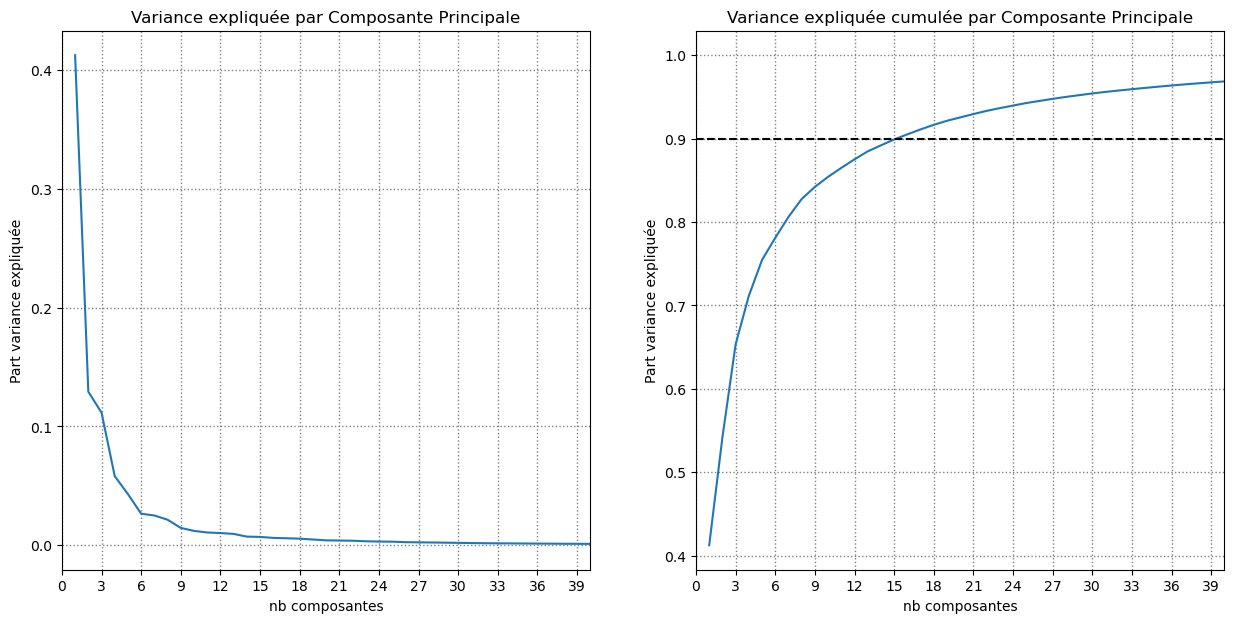

Part de la variance expliquée conservée pour 20 composantes : 92.55%


In [32]:
### Chargement des données, pré-processing et réduction des features pour images non détourées

# Création Dataframe à partir des données non détourées
df_maincolors = create_df_color(const.DATASET_TEST, nb_colors=20, without_bkg=False)

# Test valeurs manquantes : devrait être OK avec correctif fonction extract_colors_img
print(f"""
% valeurs manquantes totales : {df_maincolors.isna().sum(axis=0).sum()/(df_maincolors.shape[0]*df_maincolors.shape[1]):.2%}
""")

# df_maincolors['test_NA'] = df_maincolors.isnull().sum(axis = 1)
# display(df_maincolors)
# print(df_maincolors[df_maincolors['test_NA']>0][['echantillon','classe','nom_img','test_NA']])

# Suppression valeurs manquantes en attendant nouveau dataset suite correctif fonction extract_colors_img
df_maincolors = df_maincolors.dropna(axis = 0, how = 'any')

# # Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# # + normalisation
X_train, y_train, X_test, y_test, X_valid, y_valid = sep_data(df_maincolors, norm=True)

# # Recherche et suppression des variables de variance nulle
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).sup_var_null()

# # Visualisation ACP
display(Reduc_feat(X_train, [X_train, X_test, X_valid]).print_acp(40))

# # Éxécution ACP
X_train, X_test, X_valid = Reduc_feat(X_train, [X_train, X_test, X_valid]).exe_acp(20)


Fichier existant, chargement à partir de  
 ..\data \ ML_maincolors20_det.csv 


% valeurs manquantes totales : 0.00%

Quantité par échantillon : 
 echantillon
train    44128
test      9456
valid     9456
Name: count, dtype: int64 

Nombre de variable avec variance nulle :  0


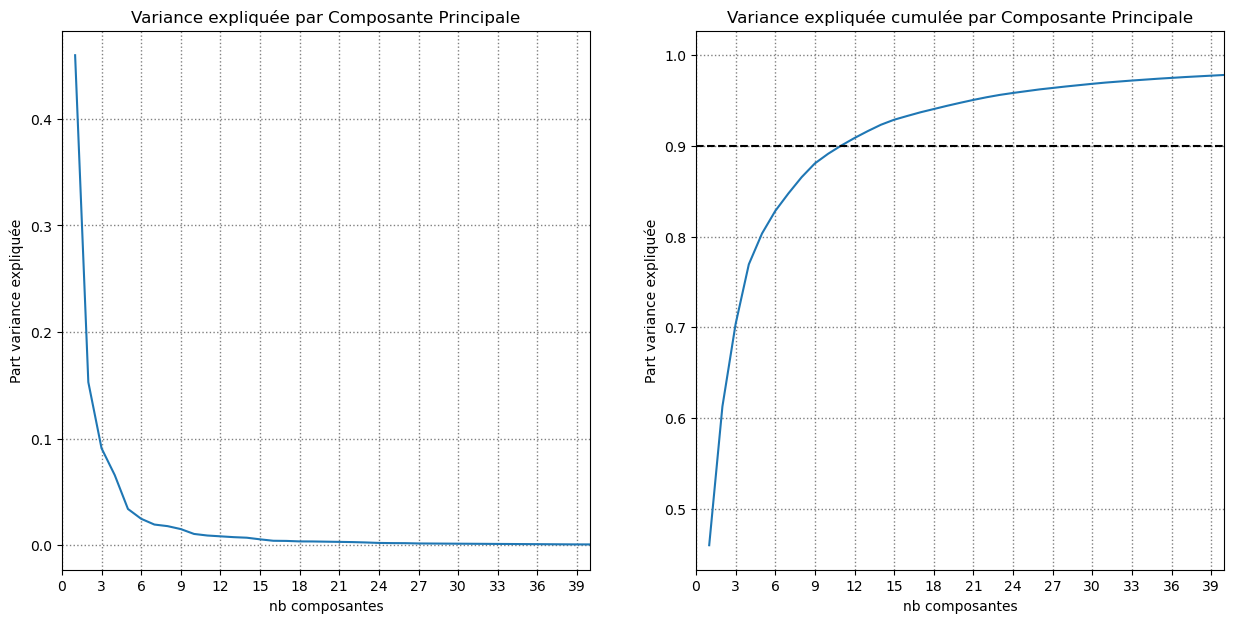

Part de la variance expliquée conservée pour 24 composantes : 95.84%


In [33]:
### Chargement des données, pré-processing et réduction des features pour images détourées

# Création Dataframe à partir des données détourées
df_maincolors_det = create_df_color(const.DATASET_TEST_WO_BACKGROUND, nb_colors=20, without_bkg=True)

# Test valeurs manquantes : devrait être OK avec correctif fonction extract_colors_img
print(f"""
% valeurs manquantes totales : {df_maincolors_det.isna().sum(axis=0).sum()/
                                (df_maincolors_det.shape[0]*df_maincolors_det.shape[1]):.2%}
""")

# df_maincolors_det['test_NA'] = df_maincolors_det.isnull().sum(axis = 1)
# display(df_maincolors)
# print(df_maincolors_det[df_maincolors_det['test_NA']>0][['echantillon','classe','nom_img','test_NA']])

# Suppression valeurs manquantes en attendant nouveau dataset suite correctif fonction extract_colors_img
# df_maincolors_det = df_maincolors_det.dropna(axis = 0, how = 'any')

# Séparation des variables explicatives de la cible selon leurs source (train, test, valid) 
# + normalisation
X_train_det, y_train_det, X_test_det, y_test_det, X_valid_det, y_valid_det = sep_data(df_maincolors_det, 
                                                                                      norm=True)

# Recherche et suppression des variables de variance nulle
X_train_det, X_test_det, X_valid_det = Reduc_feat(X_train_det, 
                                                  [X_train_det, X_test_det, X_valid_det]).sup_var_null()

# Visualisation ACP
display(Reduc_feat(X_train_det, [X_train_det, X_test_det, X_valid_det]).print_acp(40))

# Éxécution ACP
X_train_det, X_test_det, X_valid_det = Reduc_feat(X_train_det, 
                                                  [X_train_det, X_test_det, X_valid_det]).exe_acp(24)

In [37]:
### Test classification à partir des images originales (non détourées) et détourées

# Reprise fichier si déjà existant pour compléter par nouveaux tests
ML_file_path = os.path.join(const.DATA_ML_PATH, 'res_test_ml_coul.txt')

if not os.path.isfile(ML_file_path):
    print('Fichier non existant, création du fichier', '\n')
    # Initialisation paramètre reprise test
    test_prec = False
else :
    print('Fichier test existant, chargement des tests précédents', '\n')
    df_res_ml_init = pd.read_csv(ML_file_path, sep=';', header=0, encoding='ANSI')
    # Initialisation paramètre reprise test
    test_prec = True

# Nb classes à prédire
nb_cl_test = [10, 20] # [10, 20, 50, 100]

# Nombre de tests à effectuer par taille de classe
nb_test = [5, 2] # [10, 5, 2, 1]

# Source des images
source = ['1. originale', '2. détourée']

# Définition des features et target  pour les images originales (non détourées)
ds_features = [X_train, X_test, X_valid]
ds_target = [y_train, y_test, y_valid]

# Définition des features et target pour les images détourées
ds_features_det = [X_train_det, X_test_det, X_valid_det]
ds_target_det = [y_train_det, y_test_det, y_valid_det]

# Initialisation des sorties
res_ml = []
res_mdl = []
mdl_classif = ['Reg Logistique', 'Random Forest', 'Bagging', 'XGBoost']

ds_target_det = [y_train_det, y_test_det, y_valid_det]

# Éxécution des tests
for nb_cl, nb_iter in zip(nb_cl_test, nb_test):

    # Réinitialisation des noyaux utilisés pour nb de classes
    noyaux_util = []
    if test_prec == True and nb_cl in list(df_res_ml_init['Nb_classes_pred'].unique()):
        noyaux_util = list(df_res_ml_init[df_res_ml_init['Nb_classes_pred'] == nb_cl]['Noyau'].unique())

    # Reprise de la suite des itérations si tests déjà existant
    if test_prec == True and nb_cl in list(df_res_ml_init['Nb_classes_pred'].unique()):
        num_der_iter = df_res_ml_init[df_res_ml_init['Nb_classes_pred'] == nb_cl]['Iteration'].max()
    else:
        num_der_iter = 0

    for num_iter in range(1, nb_iter + 1):
        
        # Définition du noyau pour obtenir les mêmes échantillons pour les images détourées et non
        # détourées
        noyau = np.random.randint(1000)

        # Test si noyau déjà utilisé
        while noyau in noyaux_util:
            noyau = np.random.randint(1000)

        noyaux_util.append(noyau)
        
        for base, ds_f, ds_t in zip(source, 
                                      [ds_features, ds_features_det], 
                                      [ds_target, ds_target_det]):
            
            print('nb classe :', nb_cl)
            print('num_iter :', num_iter)
            print('source :', base)
            print('noyau :', noyau)

            # Sélection de x classes / images non détourées
            ds = sel_classe(nb_cl=nb_cl, ds_features=ds_f, ds_target=ds_t, 
                            noyau=noyau, representation=False)

            # liste des classes sélectionnées
            classe_sel = ''
            for i, cl in enumerate(np.unique(ds[3].values)):
                if i == 0:
                    classe_sel = cl
                else:
                    classe_sel = classe_sel + ', ' + cl

            # Classification
            res_log, res_rfc, res_bag, res_xgb = Models(ds).classif()
            res_classif = [res_log, res_rfc, res_bag, res_xgb]

            for mdl, res in zip(mdl_classif, res_classif):
                # Enregistrement du contexte du modèle
                res_mdl = []
                res_mdl.append(base)
                res_mdl.append(f'M{nb_cl}-{num_iter}')
                res_mdl.append(nb_cl)
                res_mdl.append(num_iter + num_der_iter)
                res_mdl.append(noyau)
                res_mdl.append(classe_sel)
                res_mdl.append(mdl)
                # Enregistrement des paramètres et du score du modèle
                param = list(res[mdl].values())[0]
                param = f'{param}'                  # Passage en string
                param = re.sub('\s+', ' ', param)   # Suppression des tabulsations, retour à la ligne, ...
                res_score = list(res[mdl].values())[1]
                res_mdl.append(param)
                res_mdl.append(res_score)
                # Ajout à la liste finale
                res_ml.append(res_mdl)

# Passage de la liste finale en DataFrame
df_res_ml = pd.DataFrame(res_ml, columns=['Dataset', 'Num_mod', 'Nb_classes_pred', 'Iteration', 'Noyau',
                                          'Classes_sel', 'Modele', 'Paramètres', 'Accuracy'])

# Concaténation avec historique si existe
if test_prec == True:
    df_res_ml = pd.concat([df_res_ml_init, df_res_ml], axis=0)

# sauvegarde du nouveau fichier
df_res_ml.to_csv(ML_file_path, sep=';', header=True, index=False, encoding='ANSI')

Fichier test existant, chargement des tests précédents 

nb classe : 10
num_iter : 1
source : 1. originale
noyau : 408
Classes sélectionnées :  
 ['FIERY MINIVET' 'RUDY KINGFISHER' 'BAR-TAILED GODWIT'
 'CHINESE BAMBOO PARTRIDGE' 'BROWN NOODY' 'INCA TERN'
 'WILSONS BIRD OF PARADISE' 'DARK EYED JUNCO' 'CRESTED COUA'
 'SPANGLED COTINGA'] 

regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

nb classe : 10
num_iter : 1
source : 2. détourée
noyau : 408
Classes sélectionnées :  
 ['FIERY MINIVET' 'RUDY KINGFISHER' 'BAR-TAILED GODWIT'
 'CHINESE BAMBOO PARTRIDGE' 'BROWN NOODY' 'INCA TERN'
 'WILSONS BIRD OF PARADISE' 'DARK EYED JUNCO' 'CRESTED COUA'
 'SPANGLED COTINGA'] 

regression logistique : ok
random forest classifier : ok
bagging : ok
Xgboost : ok 

nb classe : 10
num_iter : 2
source : 1. originale
noyau : 402
Classes sélectionnées :  
 ['FAIRY PENGUIN' 'VENEZUELIAN TROUPIAL' 'CROW' 'GRANDALA' 'SAND MARTIN'
 'AZURE TIT' 'DOUBLE BRESTED CORMARANT' 'NORTHERN

In [ ]:
# Uniquement si plantage étape précédente, pour récupérer tests déjà effectués et ne pas tout perdre

print(res_ml)

ML_file_path = os.path.join(const.DATA_ML_PATH, 'res_test_ml_coul.txt')

# Passage de la liste finale en DataFrame
df_res_ml = pd.DataFrame(res_ml, columns=['Dataset', 'Num_mod', 'Nb_classes_pred', 'Iteration', 'Noyau',
                                          'Classes_sel', 'Modele', 'Paramètres', 'Accuracy'])

# Concaténation avec historique si existe
if test_prec == True:
    df_res_ml = pd.concat([df_res_ml_init, df_res_ml], axis=0)

# sauvegarde du nouveau fichier
df_res_ml.to_csv(ML_file_path, sep=';', header=True, index=False, encoding='ANSI')

Fichier existant, chargement des tests éffectués 



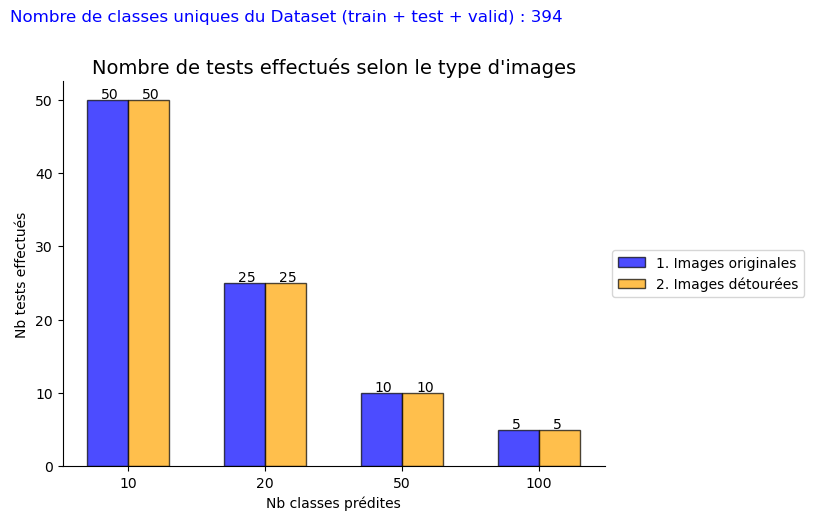

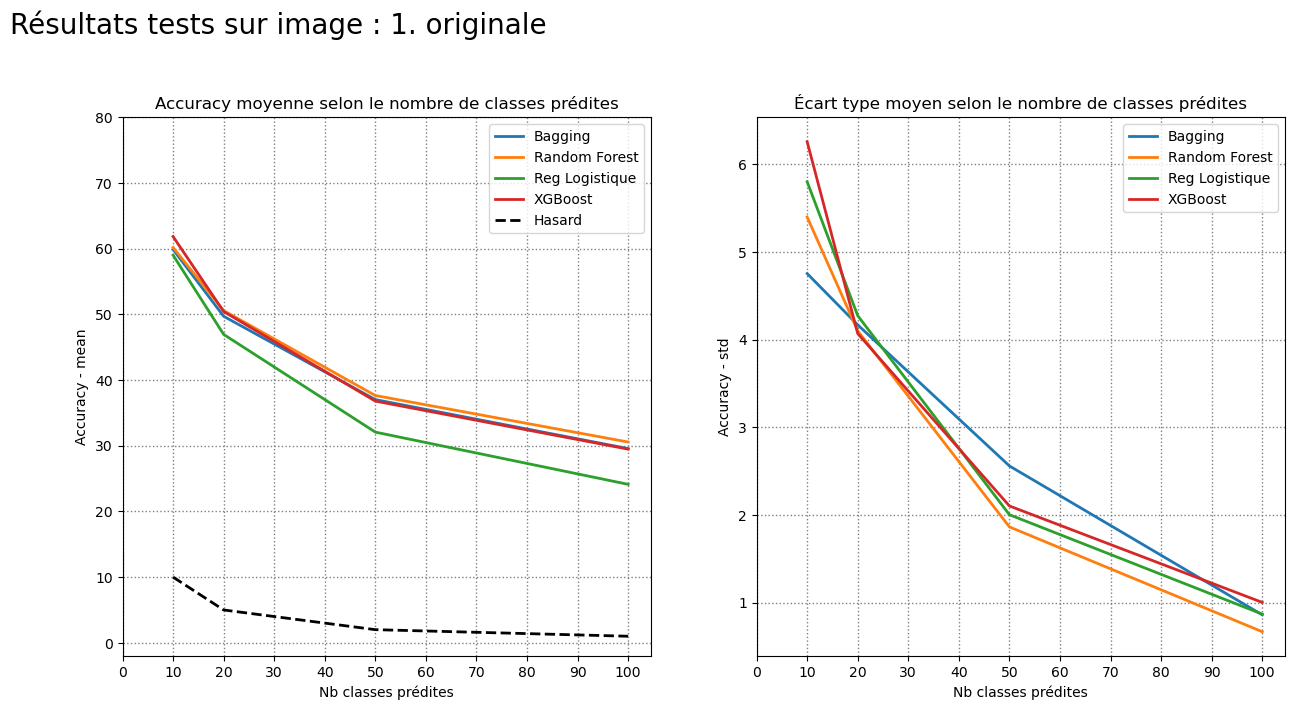

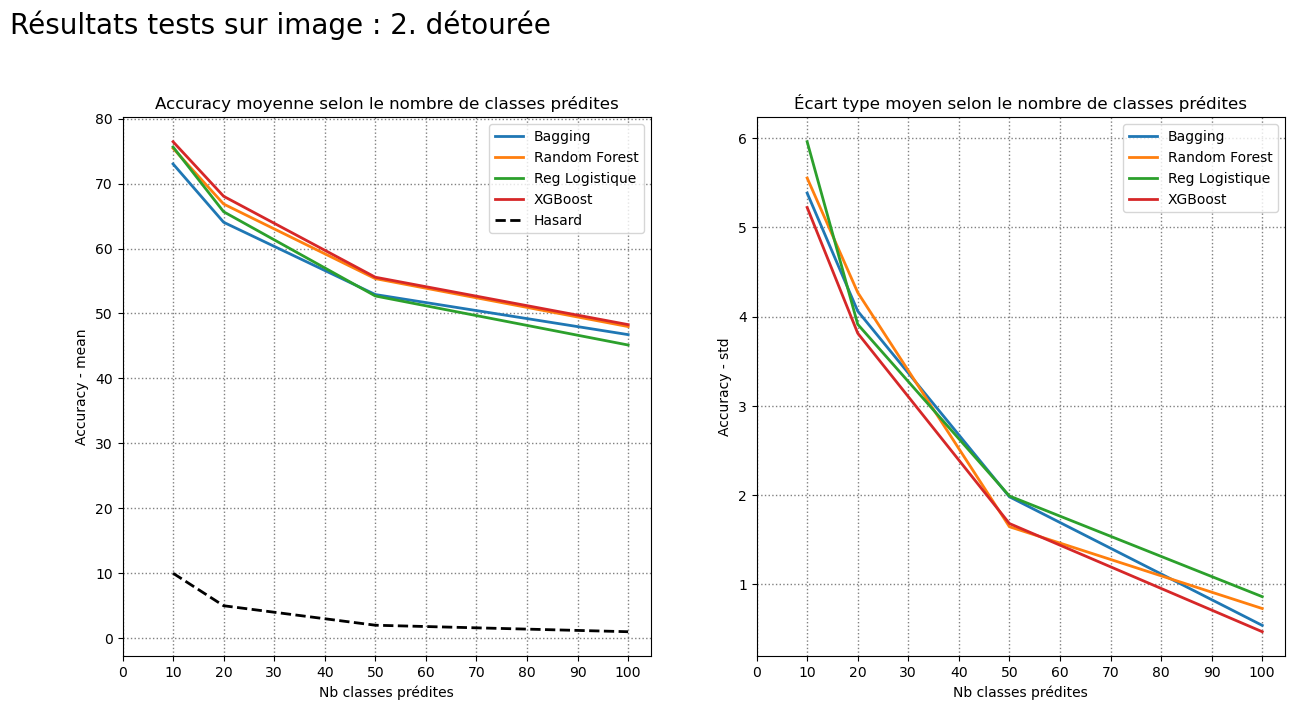

<Figure size 1500x700 with 0 Axes>

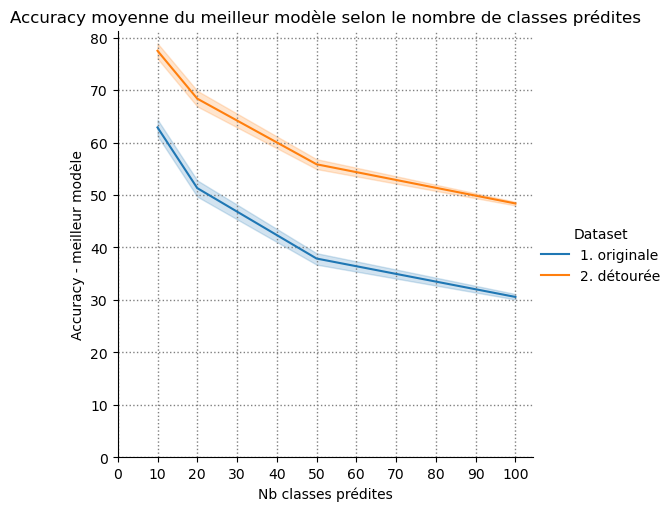

In [25]:
### Analyse des résultats de tests par modèle selon nombre de classes prédites

# Chargement fichier disponible
ML_file_path = os.path.join(const.DATA_ML_PATH, 'res_test_ml_coul.txt')

if not os.path.isfile(ML_file_path):
    print('Fichier non existant, analyse impossible', '\n')
else :
    print('Fichier existant, chargement des tests éffectués', '\n')
    df_res_ml = pd.read_csv(ML_file_path, sep=';', header=0, encoding='ANSI')

    # Bar plot sur le nombre de tests réalisés
    df_res_agg = df_res_ml.groupby(['Dataset', 'Nb_classes_pred'], as_index=False).agg({'Iteration':['max']})

    barWidth = 0.3
    df_test_ori = df_res_agg[df_res_agg['Dataset']=='1. originale']
    df_test_det = df_res_agg[df_res_agg['Dataset']=='2. détourée']
    nb_cl_tot = len(np.unique(df_maincolors_det['classe']))

    fig = plt.figure(figsize=(7, 5))
    ax1 = fig.add_subplot(111)
    x1 = range(len(np.unique(df_res_agg['Nb_classes_pred'])))
    x2 = [i + barWidth for i in x1]

    # print(len(x1), df_test_ori['Iteration']['max'].shape)
    ax1.bar(x1, df_test_ori['Iteration']['max'], color='blue', width=barWidth, edgecolor='black', 
            label='1. Images originales', alpha=0.7)
    ax1.bar(x2, df_test_det['Iteration']['max'], color='orange', width=barWidth, edgecolor='black', 
            label='2. Images détourées', alpha=0.7)
    # Ajout des valeurs sur les bars des images originales
    for index, value in zip(x1, df_test_ori['Iteration']['max']):
        plt.text(index - 0.05, value + 0.2,
        str(int(value)))
    # Ajout des valeurs sur les bars des images détourées
    for index, value in zip(x2, df_test_det['Iteration']['max']):
        plt.text(index - 0.05, value + 0.2,
        str(int(value)))
    ax1.legend(loc='upper left', edgecolor='black')
    titre = ax1.set_title("Nombre de tests effectués selon le type d'images")
    titre.set(color="black", fontsize="14") # , fontfamily="serif"
    ax1.set_xticks([0.15, 1.15, 2.15, 3.15])
    ax1.set_xticklabels(np.unique(df_res_agg['Nb_classes_pred']))
    ax1.set_xlabel('Nb classes prédites')
    ax1.set_ylabel('Nb tests effectués')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.text(0.05, 1, f"Nombre de classes uniques du Dataset (train + test + valid) : {nb_cl_tot:.0f}", 
            fontsize=12, transform=plt.gcf().transFigure, color='blue')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    plt.show()
    
    # Données agrégées
    df_res_agg = df_res_ml.groupby(['Dataset', 'Nb_classes_pred', 'Modele'], 
                                   as_index=False).agg({'Accuracy':['count', 'mean', 'std']})

    # Création des graphiques par origine
    for ori in df_res_agg['Dataset'].unique() :
                          
        base_graph = df_res_agg[df_res_agg['Dataset'] == ori]

        fig = plt.figure(figsize=(15, 7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        fig.text(0.05, 1, f"Résultats tests sur image : {ori}", 
                 fontsize=20, transform=plt.gcf().transFigure, color='black')

        for mdl in base_graph['Modele'].unique():
            x = base_graph[base_graph['Modele'] == mdl]['Nb_classes_pred']
            y1 = base_graph[base_graph['Modele'] == mdl]['Accuracy']['mean'] * 100
            y2 = base_graph[base_graph['Modele'] == mdl]['Accuracy']['std'] * 100
            ax1.plot(x, y1, label=mdl, linewidth=2)
            ax2.plot(x, y2, label=mdl, linewidth=2)

        # Hasard
        x = base_graph['Nb_classes_pred'].unique()
        y = 100 / x
        ax1.plot(x, y, '--k', label='Hasard', linewidth=2)

        # Mise en forme
        ax1.set_xticks(np.arange(0, 110, 10))
        ax1.set_yticks(np.arange(0, 90, 10))
        ax1.set_title('Accuracy moyenne selon le nombre de classes prédites')
        ax1.set_xlabel('Nb classes prédites')
        ax1.set_ylabel('Accuracy - mean')
        ax1.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
        ax1.legend()
        ax2.set_xticks(np.arange(0, 110, 10))
        ax2.set_title('Écart type moyen selon le nombre de classes prédites')
        ax2.set_xlabel('Nb classes prédites')
        ax2.set_ylabel('Accuracy - std')
        ax2.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
        ax2.legend()
    
    # Comparaison entre image originale et détourée
    df_res_agg = df_res_ml.groupby(['Dataset', 'Nb_classes_pred', 'Iteration'], 
                                   as_index=False)['Accuracy'].max()
    
    df_res_agg['Accuracy'] = df_res_agg['Accuracy'] * 100

    fig = plt.figure(figsize=(15, 7))
    ax1 = sns.relplot(x='Nb_classes_pred', y='Accuracy', kind='line', hue='Dataset', data=df_res_agg)
    plt.xticks(np.arange(0, 110, 10))
    plt.yticks(np.arange(0, 90, 10))
    plt.title('Accuracy moyenne du meilleur modèle selon le nombre de classes prédites')
    plt.xlabel('Nb classes prédites')
    plt.ylabel('Accuracy - meilleur modèle')
    plt.grid(visible=True, which='major', axis='both', color='grey', linestyle=':', linewidth=1)
    plt.show()

480


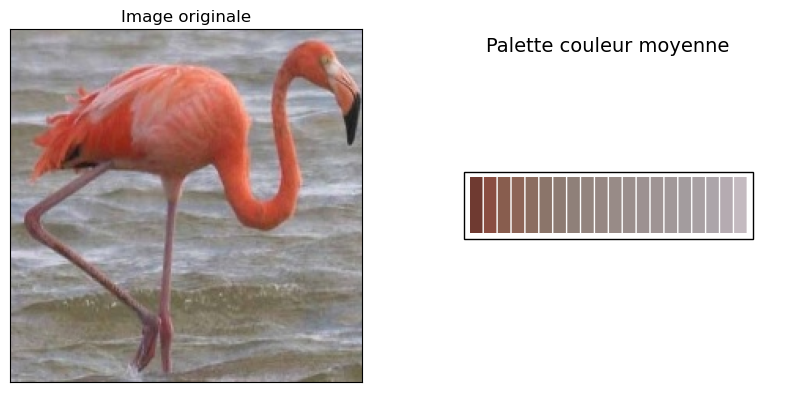

In [197]:
### test fonction extraction couleur

## Images non détourées
without_bkg = False
# path = '..\\data\\dataset_birds_test\\test\\ALBERTS TOWHEE\\32.JPG'
path = '..\\data\\dataset_birds_test\\train\\AMERICAN FLAMINGO\\27.JPG'
# path = '..\\data\\\dataset_birds_test\\test\AMERICAN AVOCET\\69.JPG'
# path = '..\\data\\dataset_birds_test\\test\\ABBOTTS BABBLER\\1.JPG'

# Images "spéciales"
# path = '..\\data\\dataset_birds_test\\test\\ALPINE CHOUGH\\6.JPG'
# path = '..\\data\\dataset_birds_test\\test\\AMERICAN FLAMINGO\\33.JPG'
# path = '..\\data\\dataset_birds_test\\valid\\WALL CREAPER\\116.JPG'

## Images détourées
# without_bkg = True
# path = '..\\data\\dataset_birds_test_wo_background\\train\\BUSH TURKEY\\17.JPG'

nb_colors = 20
res = extract_colors_img(path, nb_colors, without_bkg=without_bkg)

print(len(res))
# Récupération données
recup_res = []
for num, i in enumerate(range(0, len(res), 24)):
    # print(i, i+6, i+12)
    recup_res.append([f'C{num+1}', res[i], res[i+6], res[i+12]])

df_img_sort = pd.DataFrame(recup_res, columns=['decoup_', 'R_mean', 'G_mean', 'B_mean'])

# Pour affichage palette
demo_coul_moy = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
demo_coul_moy[:,:,:] = 255

demo_coul_med = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
demo_coul_med[:,:,:] = 255

deb = 0
fin = 9

for i in range(0, nb_colors, 1):
    demo_coul_moy[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
                                    [['R_mean', 'G_mean', 'B_mean']].round(0))
    # demo_coul_med[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
    #                                 [['R_q1', 'G_q1', 'B_q1']].round(0))
    deb = fin + 1 
    fin += 10

plt.figure(figsize=(10,5))

# Image originale
img = cv2.imread(path)
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

ax = plt.subplot(122)
# plt.imshow(demo_coul)
ax.text(0.15, 0.9, 'Palette couleur moyenne', fontsize=14)
# ax.text(0.15, 0.4, 'Palette couleur médiane', fontsize=14)
imagebox1 = AnnotationBbox(OffsetImage(demo_coul_moy), [0.5, 0.5])
# imagebox2 = AnnotationBbox(OffsetImage(demo_coul_med), [0.5, 0.25])
ax.add_artist(imagebox1)
# ax.add_artist(imagebox2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.show()

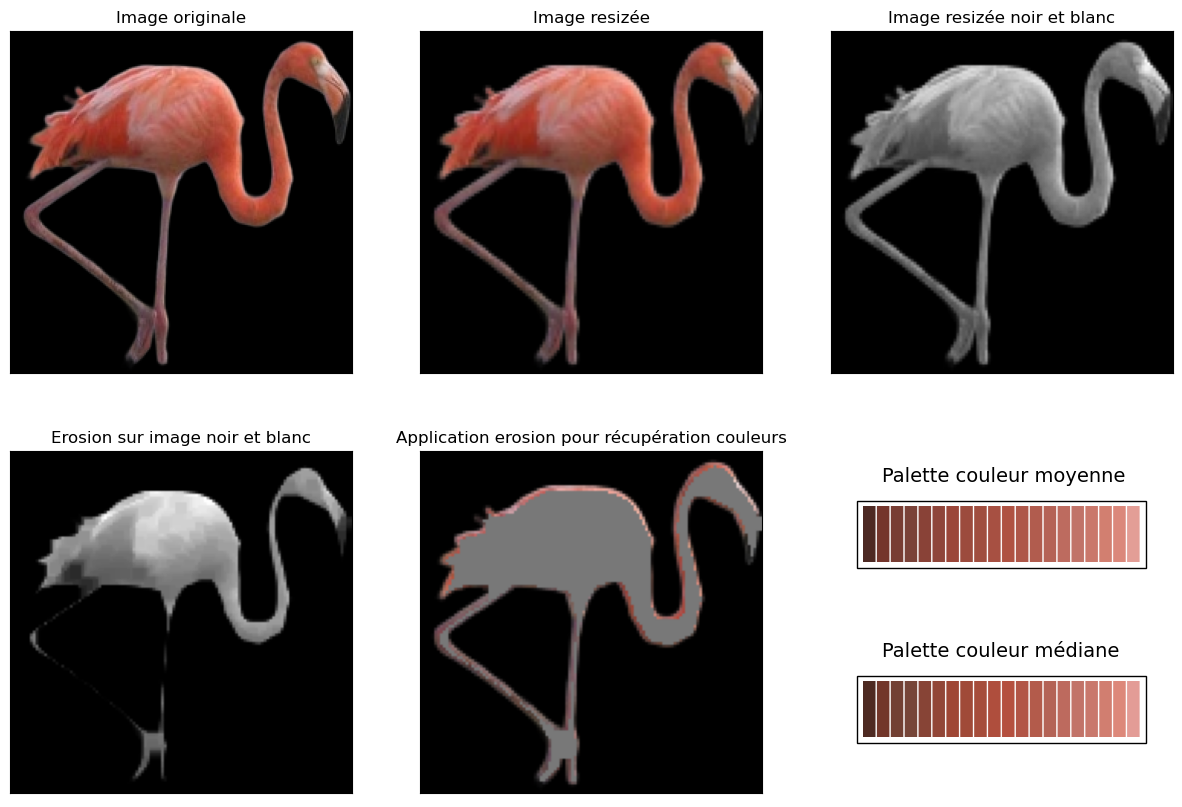

In [62]:
### Démo pour images détourées

## Images "spéciales" (avec valeurs manquantes)
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BULWERS PHEASANT\\55.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\LAUGHING GULL\\209.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\WALL CREAPER\\147.JPG')

## Images pas ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN PIED HORNBILL\\164.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\45.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ASIAN CRESTED IBIS\\126.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ALPINE CHOUGH\\42.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\BUSH TURKEY\\17.JPG')

## Images ok avec 1er code
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN FLAMINGO\\27.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AMERICAN AVOCET\\69.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\1.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\ABBOTTS BABBLER\\134.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\train\\ALPINE CHOUGH\\8.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\CROW\\20.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\AFRICAN EMERALD CUCKOO\\114.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test_wo_background\\test\\YELLOW BREASTED CHAT\\60.JPG')


# Taille image resizée
img_width = 120
img_height = 120

# seuil érosion
seuil_ero = 2

# Nb de couleurs souhaitées dans palette
nb_colors = 20

# Affichage image originale
plt.figure(figsize = (15,10))
plt.subplot(231)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Resize image et affichage
img_color = cv2.resize(img, dsize = (img_width,img_height)) 

plt.subplot(232)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image resizée')

# Passage en noir et blanc et affichage
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.subplot(233)
plt.imshow(img_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Image resizée noir et blanc')

# Erosion et affichage
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(img_gray, kernel)
plt.subplot(234)
plt.imshow(erosion, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Erosion sur image noir et blanc')

erosion_gray = erosion.reshape(img_width*img_height, 1)
erosion = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
erosion = erosion.reshape(img_width*img_height, 3)

# Application erosion à image en noir et blanc
img_sort_gray = img_gray.reshape(img_width*img_height, 1)
img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]

# Test découpage et ajustement seuil si besoin
decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors), axis=0))

# Ajustement seuil érosion (5 maximum)
# print(seuil_ero)
while len(np.unique(decoup)) <= nb_colors and seuil_ero<5:
    seuil_ero += 1
    img_sort_gray = img_gray.reshape(img_width*img_height, 1)
    img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]
    decoup = list(np.percentile(img_sort_gray[:, 0], np.arange(0, 101, 100/nb_colors), axis=0))
    # print(seuil_ero)

# Exlusion des pixels totalement blancs (problème image)
erosion[(erosion[:,0] > (255 - seuil_ero)) & 
        (erosion[:,1] > (255 - seuil_ero)) & 
        (erosion[:,2] > (255 - seuil_ero))] = 0

# Application érosion sur image couleur
img_sort_color = img_color.reshape(img_width*img_height, 3).copy()

img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                (erosion[:,1] > seuil_ero) |
                                (erosion[:,2] > seuil_ero)]

# Découpage sur R + G + B
decoup_source = np.sum(img_sort_color, axis=1)
decoup_source.shape = (len(decoup_source), 1)
decoup_source = np.concatenate([img_sort_color, decoup_source], axis = 1)
decoup = list(np.percentile(decoup_source[:, 3], np.arange(0, 101, 100/nb_colors), axis=0))

# print(decoup)

cpt = 0
if len(np.unique(decoup)) <= nb_colors:
    decoup_temp = decoup.copy()
    decoup.clear()
    for val in decoup_temp:
        # print(decoup)
        while val <= (cpt + 1):
            val = val + 2
        # print('Ajout')
        cpt = val
        decoup.append(int(val))

# print(decoup)

# Application érosion sur image couleur pour affichage
img_color_sel = img_color.reshape(img_width*img_height, 3).copy()
img_color_sel[(erosion[:,0] > seuil_ero) | (erosion[:,1] > seuil_ero) | (erosion[:,2] > seuil_ero)] = 120
img_color_sel = img_color_sel.reshape(img_width, img_height, 3)

plt.subplot(235)
plt.imshow(cv2.cvtColor(img_color_sel, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Application erosion pour récupération couleurs')

# Application érosion sur image couleur
img_sort_color = img_color.reshape(img_width*img_height, 3)

img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                (erosion[:,1] > seuil_ero) |
                                (erosion[:,2] > seuil_ero)]

# Passage en DataFrame
df_img_gray = pd.DataFrame(img_sort_gray, columns=['Gray'])
df_img_color = pd.DataFrame(decoup_source, columns=['B','G','R','TOT'])

df_img = pd.concat([df_img_gray, df_img_color], axis=1)

# Découpage couleurs
nom_inter = []
for inter in range(1, nb_colors+1, 1):
    nom_inter.append(f'C{str(inter)}')

# print(nom_inter)
# df_img['tot'] = df_img.apply(lambda row : row['R'] + row['G'] + row['B'], axis=1)
df_img['decoup'] = pd.cut(x = df_img['TOT'], bins = decoup, 
                          labels = nom_inter, include_lowest = True)

df_img.to_csv(os.path.join(const.DATASET_TEST_WO_BACKGROUND, 'test.txt'), sep=';', header=True, 
             index=False, encoding='ANSI')

# Calcul des indicateurs
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def iqr(x):
    return q3(x) - q1(x) 

calculs = {'R':['mean', 'std', 'median', q1, q3, iqr],
           'G':['mean', 'std', 'median', q1, q3, iqr],
           'B':['mean', 'std', 'median', q1, q3, iqr],
           'Gray':['mean', 'std', 'median', q1, q3, iqr]}

df_img_sort = df_img.groupby('decoup', as_index=False).agg(calculs).round(1)

# df_img_sort.columns = ['_'.join(col) for col in df_img_sort.columns.values]
df_img_sort = df_img_sort.set_axis(df_img_sort.columns.map('_'.join), axis=1)

# Gestion des valeurs manquantes
df_img_sort['Test_NaN'] = df_img_sort.isna().any(axis = 1)

for i in range(0, nb_colors, 1):
    # print(f"test C{i+1}")
    if df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']['Test_NaN'].values == True:
        # Récupération données classe précédente
        df_img_sort.iloc[i,1:25] = df_img_sort.iloc[i-1, 1:25]
        
# Pour affichage palette
demo_coul_moy = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
demo_coul_moy[:,:,:] = 255

demo_coul_med = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
demo_coul_med[:,:,:] = 255

deb = 0
fin = 9

for i in range(0, nb_colors, 1):
    demo_coul_moy[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
                                    [['R_mean', 'G_mean', 'B_mean']].round(0))
    demo_coul_med[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
                                    [['R_median', 'G_median', 'B_median']].round(0))
    deb = fin + 1 
    fin += 10

ax = plt.subplot(236)
# plt.imshow(demo_coul)
ax.text(0.15, 0.9, 'Palette couleur moyenne', fontsize=14)
ax.text(0.15, 0.4, 'Palette couleur médiane', fontsize=14)
imagebox1 = AnnotationBbox(OffsetImage(demo_coul_moy), [0.5, 0.75])
imagebox2 = AnnotationBbox(OffsetImage(demo_coul_med), [0.5, 0.25])
ax.add_artist(imagebox1)
ax.add_artist(imagebox2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

rep_color_img = []
# Passage des informations en colonne pour chaque couleur
for i in range(0, df_img_sort.shape[0]):
    # print(list(df_img_sort.iloc[i,-20:]))
    if i == 0:
        rep_color_img = list(df_img_sort.iloc[i,-24:])
    else:
        rep_color_img.extend(list(df_img_sort.iloc[i,-24:]))

# print(df_img_sort.shape[1], '\n')
# print(df_img_sort.loc[1, :], '\n')
# print(len(rep_color_img), '\n', rep_color_img)


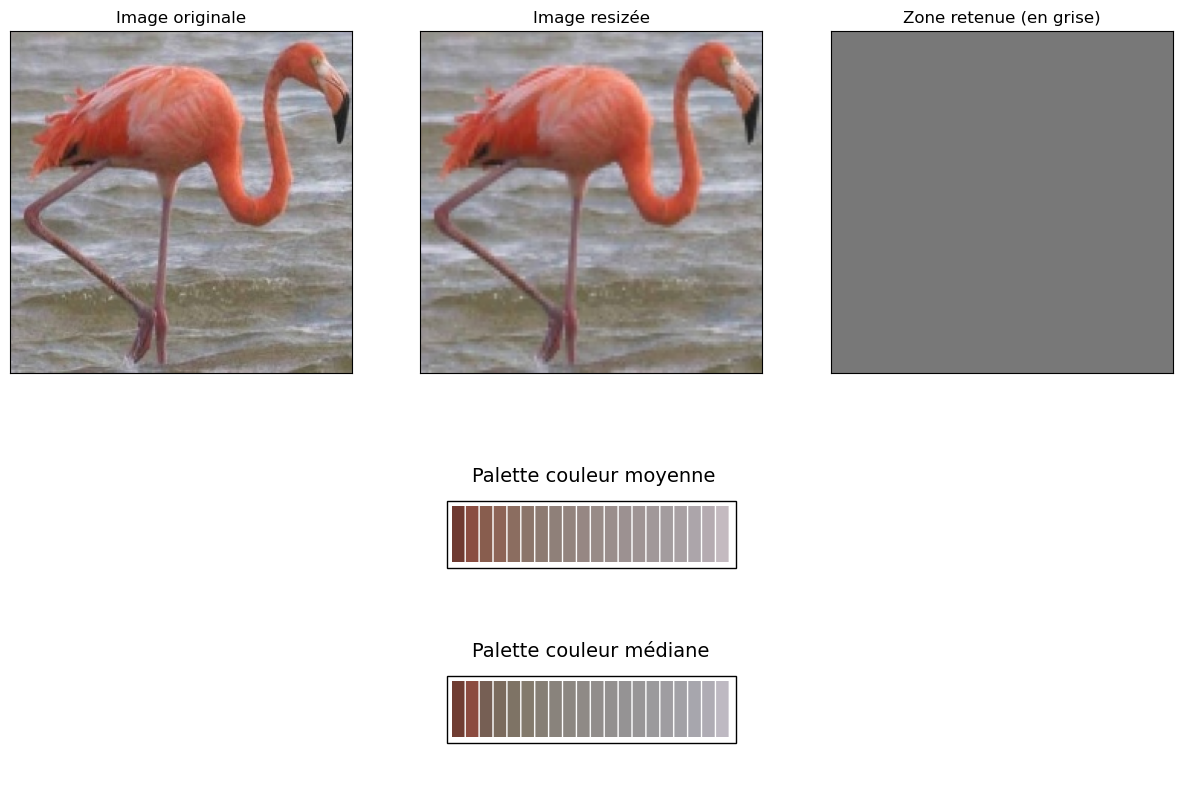

In [40]:
### Démo pour images non détourées

## Images "spéciales"
# img = cv2.imread('..\\data\\dataset_birds_test\\test\\ALPINE CHOUGH\\6.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test\\test\\AMERICAN FLAMINGO\\33.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test\\valid\\WALL CREAPER\\116.JPG')

## Images test
# img = cv2.imread('..\\data\\dataset_birds_test\\test\\ALBERTS TOWHEE\\32.JPG')
img = cv2.imread('..\\data\\dataset_birds_test\\train\\AMERICAN FLAMINGO\\27.JPG')
# img = cv2.imread('..\\data\\\dataset_birds_test\\test\AMERICAN AVOCET\\69.JPG')
# img = cv2.imread('..\\data\\dataset_birds_test\\test\\ABBOTTS BABBLER\\1.JPG')

# Taille image resizée
img_width = 120
img_height = 120

# Seuil correction
seuil_ero = 5

# Nb de couleurs souhaitées dans palette
nb_colors = 20

# Affichage image originale
plt.figure(figsize = (15,10))
plt.subplot(231)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

# Resize image et affichage
img_color = cv2.resize(img, dsize = (img_width,img_height)) 

plt.subplot(232)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image resizée')

img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Exlusion des pixels totalement blancs (problème image)
erosion = img_color.reshape(img_width*img_height, 3).copy()
erosion[(erosion[:,0] > (255 - seuil_ero)) & 
        (erosion[:,1] > (255 - seuil_ero)) & 
        (erosion[:,2] > (255 - seuil_ero))] = 0

# Application érosion sur image couleur pour affichage
img_color_sel = img_color.reshape(img_width*img_height, 3).copy()
img_color_sel[(erosion[:,0] > seuil_ero) | (erosion[:,1] > seuil_ero) | (erosion[:,2] > seuil_ero)] = 120
img_color_sel = img_color_sel.reshape(img_width, img_height, 3)

plt.subplot(233)
plt.imshow(cv2.cvtColor(img_color_sel, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Zone retenue (en grise)')

# Application érosion sur image couleur
img_sort_color = img_color.reshape(img_width*img_height, 3)

img_sort_color = img_sort_color[(erosion[:,0] > seuil_ero) |
                                (erosion[:,1] > seuil_ero) |
                                (erosion[:,2] > seuil_ero)]

# Application erosion à image en noir et blanc
img_sort_gray = img_gray.reshape(img_width*img_height, 1)
img_sort_gray = img_sort_gray[(erosion[:,0] > seuil_ero) |
                              (erosion[:,1] > seuil_ero) | 
                              (erosion[:,2] > seuil_ero)]

# Découpage sur R + G + B
decoup_source = np.sum(img_sort_color, axis=1)
decoup_source.shape = (len(decoup_source), 1)
decoup_source = np.concatenate([img_sort_color, decoup_source], axis = 1)
decoup = list(np.percentile(decoup_source[:, 3], np.arange(0, 101, 100/nb_colors), axis=0))

# Modification découpage si nombre de valeurs distinctes toujours pas ok
# print(decoup)
cpt = 0
if len(np.unique(decoup)) <= nb_colors:
    decoup_temp = decoup.copy()
    decoup.clear()
    for val in decoup_temp:
        # print(decoup)
        while val <= (cpt + 1):
            val = val + 2
        # print('Ajout')
        cpt = val
        decoup.append(int(val))

# print(decoup)
# Passage en DataFrame
df_img_gray = pd.DataFrame(img_sort_gray, columns=['Gray'])
df_img_color = pd.DataFrame(decoup_source, columns=['B','G','R','TOT'])

df_img = pd.concat([df_img_gray, df_img_color], axis=1)

# Découpage couleurs
nom_inter = []
for inter in range(1, nb_colors+1, 1):
    nom_inter.append(f'C{str(inter)}')

df_img['decoup'] = pd.cut(x = df_img['TOT'], bins = decoup, labels = nom_inter, include_lowest = True)

# Calcul des indicateurs
calculs = {'R':['mean', 'std', 'median', q1, q3, iqr],
           'G':['mean', 'std', 'median', q1, q3, iqr],
           'B':['mean', 'std', 'median', q1, q3, iqr],
           'Gray':['mean', 'std', 'median', q1, q3, iqr]}

df_img_sort = df_img.groupby('decoup', as_index=False).agg(calculs).round(1)

# Renommage des colonnes
df_img_sort = df_img_sort.set_axis(df_img_sort.columns.map('_'.join), axis=1)

# Gestion des valeurs manquantes
df_img_sort['Test_NaN'] = df_img_sort.isna().any(axis = 1)

for i in range(0, nb_colors, 1):
    # print(f"test C{i+1}")
    if df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']['Test_NaN'].values == True:
        # Récupération données classe précédente
        df_img_sort.iloc[i,1:25] = df_img_sort.iloc[i-1, 1:25]

# print(df_img_sort)

# Pour affichage palette
demo_coul_moy = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
demo_coul_moy[:,:,:] = 255

demo_coul_med = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
demo_coul_med[:,:,:] = 255

deb = 0
fin = 9

for i in range(0, nb_colors, 1):
    demo_coul_moy[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
                                    [['R_mean', 'G_mean', 'B_mean']].round(0))
    demo_coul_med[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
                                    [['R_median', 'G_median', 'B_median']].round(0))
    deb = fin + 1 
    fin += 10

ax = plt.subplot(235)
# plt.imshow(demo_coul)
ax.text(0.15, 0.9, 'Palette couleur moyenne', fontsize=14)
ax.text(0.15, 0.4, 'Palette couleur médiane', fontsize=14)
imagebox1 = AnnotationBbox(OffsetImage(demo_coul_moy), [0.5, 0.75])
imagebox2 = AnnotationBbox(OffsetImage(demo_coul_med), [0.5, 0.25])
ax.add_artist(imagebox1)
ax.add_artist(imagebox2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

rep_color_img = []
# Passage des informations en colonne pour chaque couleur
for i in range(0, df_img_sort.shape[0]):
    # print(list(df_img_sort.iloc[i,-20:]))
    if i == 0:
        rep_color_img = list(df_img_sort.iloc[i,-24:])
    else:
        rep_color_img.extend(list(df_img_sort.iloc[i,-24:]))

# print(df_img_sort.shape[1], '\n')
# print(df_img_sort.loc[1, :], '\n')
# print(len(rep_color_img), '\n', rep_color_img)


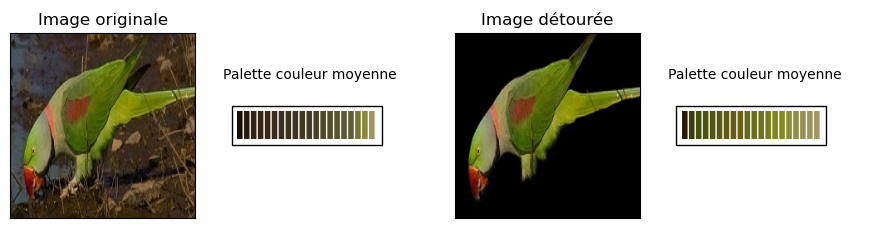

In [41]:
### Illustration écart entre image origine et détourée

## Images non détourées
without_bkg_ori = False
# path = '..\\data\\dataset_birds_test\\test\\ALBERTS TOWHEE\\32.JPG'
# path_ori = '..\\data\\dataset_birds_test\\train\\AMERICAN FLAMINGO\\27.JPG'
path_ori = '..\\data\\dataset_birds_test\\train\\ALEXANDRINE PARAKEET\\41.JPG'
# path = '..\\data\\\dataset_birds_test\\test\AMERICAN AVOCET\\69.JPG'
# path = '..\\data\\dataset_birds_test\\test\\ABBOTTS BABBLER\\1.JPG'

## Images détourées
without_bkg_det = True
path_det = '..\\data\\dataset_birds_test_wo_background\\test\\ALEXANDRINE PARAKEET\\41.JPG'

nb_colors = 20
res_ori = extract_colors_img(path_ori, nb_colors, without_bkg=without_bkg_ori)
res_det = extract_colors_img(path_det, nb_colors, without_bkg=without_bkg_det)

# Récupération données
recup_res_ori = []
for num, i in enumerate(range(0, len(res_ori), 24)):
    # print(i, i+6, i+12)
    recup_res_ori.append([f'C{num+1}', res_ori[i], res_ori[i+6], res_ori[i+12]])

recup_res_det = []
for num, i in enumerate(range(0, len(res_det), 24)):
    # print(i, i+6, i+12)
    recup_res_det.append([f'C{num+1}', res_det[i], res_det[i+6], res_det[i+12]])

df_img_sort_ori = pd.DataFrame(recup_res_ori, columns=['decoup_', 'R_mean', 'G_mean', 'B_mean'])
df_img_sort_det = pd.DataFrame(recup_res_det, columns=['decoup_', 'R_mean', 'G_mean', 'B_mean'])

# Pour affichage palette
demo_coul_moy_ori = np.zeros(shape=(nb_colors, nb_colors*5, 3), dtype=int)
demo_coul_moy_ori[:,:,:] = 255

demo_coul_moy_det = np.zeros(shape=(nb_colors, nb_colors*5, 3), dtype=int)
demo_coul_moy_det[:,:,:] = 255
# demo_coul_med = np.zeros(shape=(nb_colors*2, nb_colors*10, 3), dtype=int)
# demo_coul_med[:,:,:] = 255

deb = 0
fin = 4

for i in range(0, nb_colors, 1):
    demo_coul_moy_det[:,deb:fin,:] = np.array(df_img_sort_det[df_img_sort_det['decoup_'] == f'C{i+1}']
                                    [['R_mean', 'G_mean', 'B_mean']].round(0))
    demo_coul_moy_ori[:,deb:fin,:] = np.array(df_img_sort_ori[df_img_sort_ori['decoup_'] == f'C{i+1}']
                                    [['R_mean', 'G_mean', 'B_mean']].round(0))
    # demo_coul_med[:,deb:fin,:] = np.array(df_img_sort[df_img_sort['decoup_'] == f'C{i+1}']
    #                                 [['R_q1', 'G_q1', 'B_q1']].round(0))
    deb = fin + 1 
    fin += 5

plt.figure(figsize=(11,3))

# Image originale
img = cv2.imread(path_ori)
plt.subplot(141)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image originale')

ax = plt.subplot(142)
# plt.imshow(demo_coul)
ax.text(-0.05, 0.7, 'Palette couleur moyenne', fontsize=10)
# ax.text(0.15, 0.4, 'Palette couleur médiane', fontsize=14)
imagebox1 = AnnotationBbox(OffsetImage(demo_coul_moy_ori), [0.4, 0.5])
# imagebox2 = AnnotationBbox(OffsetImage(demo_coul_med), [0.5, 0.25])
ax.add_artist(imagebox1)
# ax.add_artist(imagebox2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

# Image détourée
img = cv2.imread(path_det)
plt.subplot(143)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Image détourée')

ax = plt.subplot(144)
# plt.imshow(demo_coul)
ax.text(-0.05, 0.7, 'Palette couleur moyenne', fontsize=10)
# ax.text(0.15, 0.4, 'Palette couleur médiane', fontsize=14)
imagebox1 = AnnotationBbox(OffsetImage(demo_coul_moy_det), [0.4, 0.5])
# imagebox2 = AnnotationBbox(OffsetImage(demo_coul_med), [0.5, 0.25])
ax.add_artist(imagebox1)
# ax.add_artist(imagebox2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.show()

In [23]:
# Pour test isolé
nb_cl = 10
noyau = 25

ds = sel_classe(nb_cl=nb_cl, ds_features=[X_train_det, X_test_det, X_valid_det], 
                ds_target=[y_train_det, y_test_det, y_valid_det],
                noyau=noyau, representation=False)

print(Models(ds).reg_log())

print(Models(ds).rfc())

print(Models(ds).bag())

print(Models(ds).ext_grad_boost())

Classes sélectionnées :  
 ['COMMON POORWILL' 'SATYR TRAGOPAN' 'LOONEY BIRDS' 'TROPICAL KINGBIRD'
 'PARUS MAJOR' 'ROUGH LEG BUZZARD' 'GYRFALCON' 'SAMATRAN THRUSH'
 'YELLOW CACIQUE' 'APAPANE'] 

{'Reg Logistique': {'parametres': LogisticRegression(C=0.1, n_jobs=-1), 'score': 0.775}}
{'Random Forest': {'parametres': RandomForestClassifier(criterion='entropy', max_depth=50, max_features='log2',
                       n_jobs=-1), 'score': 0.812}}
{'Bagging': {'parametres': BaggingClassifier(n_estimators=100, n_jobs=-1), 'score': 0.742}}
{'XGBoost': {'parametres': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=